C:\Users\ramco\AppData\Local\Temp\ipykernel_10556\2997637350.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders_df = pd.read_sql_query("SELECT OrderID, CustomerID FROM Orders", export_conn)
C:\Users\ramco\AppData\Local\Temp\ipykernel_10556\2997637350.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_details_df = pd.read_sql_query("SELECT OrderID, UnitPrice, Quantity, Discount FROM [Order Details]", export_conn)


Average Order Value: 1525.0518533580353


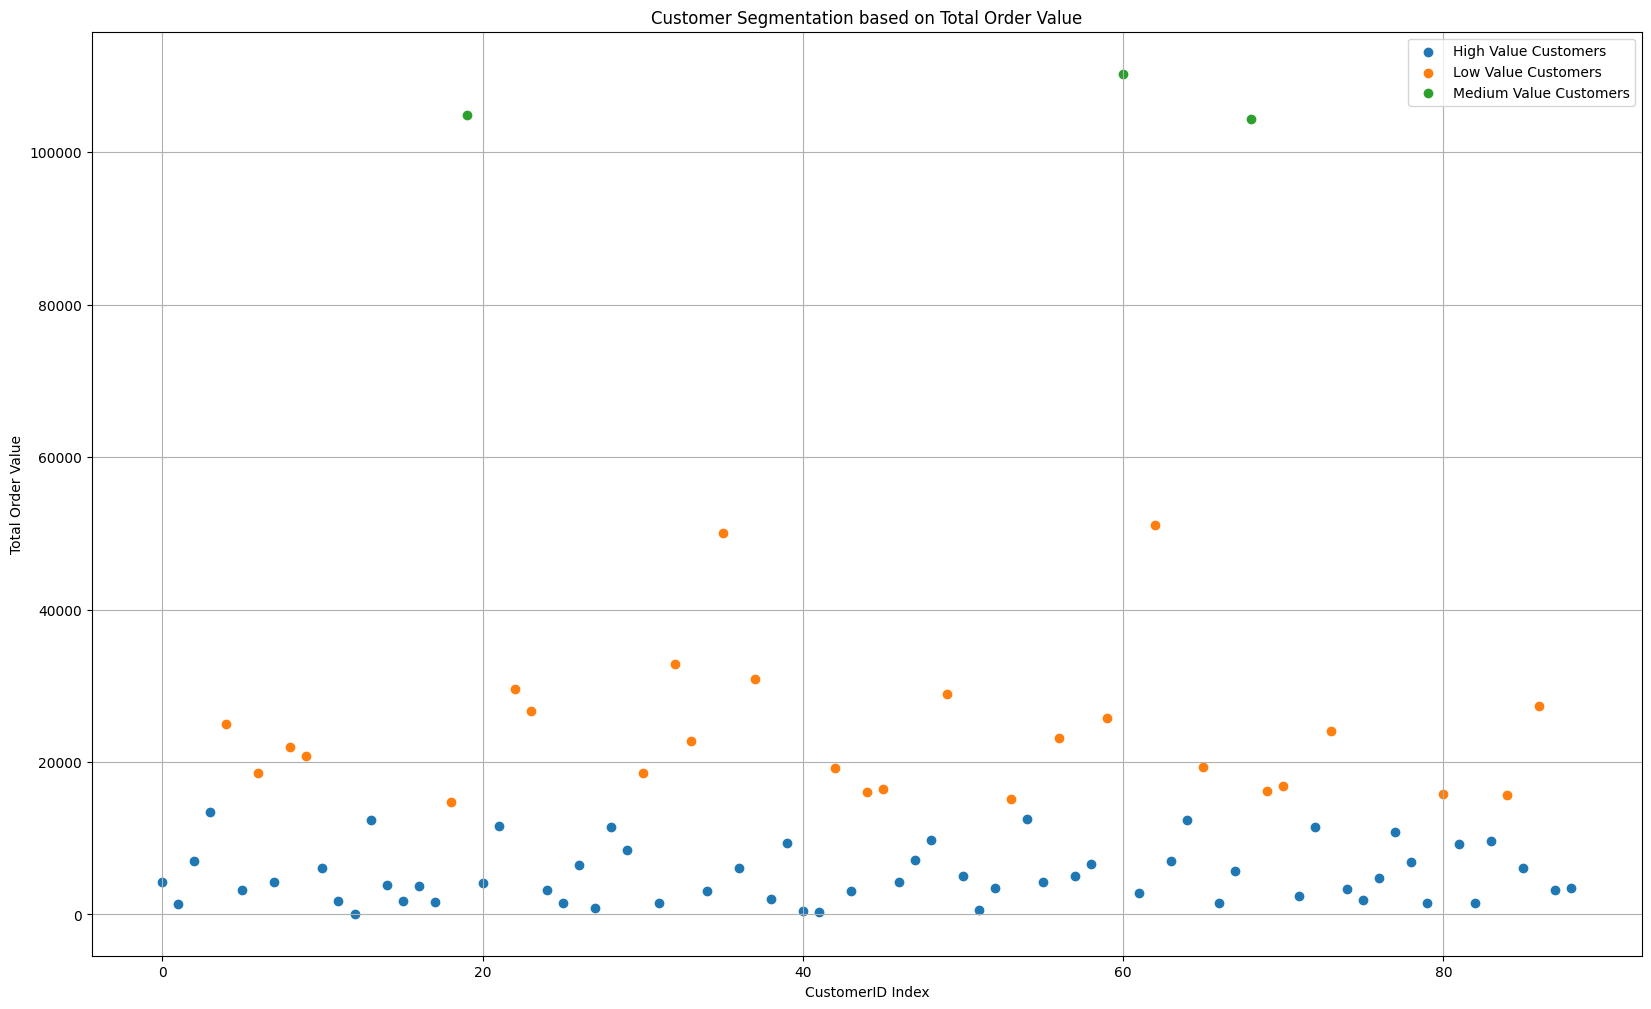

Mean Squared Error: 0.011800000000000001


In [1]:
import pyodbc
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Verbinding maken met de Northwind-database
DB = {'servername': 'LAPTOP-JCB37LKM\SQLEXPRESS',
      'database': 'NorthWind'}

export_conn = pyodbc.connect('DRIVER={SQL Server};SERVER='+ DB['servername'] + ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')

# Ophalen van relevante data uit de database
orders_df = pd.read_sql_query("SELECT OrderID, CustomerID FROM Orders", export_conn)
order_details_df = pd.read_sql_query("SELECT OrderID, UnitPrice, Quantity, Discount FROM [Order Details]", export_conn)

# Berekenen van de totale orderwaarde voor elke order
order_details_df['OrderValue'] = order_details_df['UnitPrice'] * order_details_df['Quantity'] * (1 - order_details_df['Discount'])

# Samenvoegen van orders en orderdetails om de totale orderwaarde per order te berekenen
merged_orders_df = pd.merge(orders_df, order_details_df, on='OrderID', how='left')

# Berekenen van de gemiddelde orderwaarde
average_order_value = merged_orders_df.groupby('OrderID')['OrderValue'].sum().mean()
print(f"Average Order Value: {average_order_value}")

# Klanten segmenteren op basis van de totale orderwaarde per klant
customer_order_value = merged_orders_df.groupby('CustomerID')['OrderValue'].sum().reset_index()

# Fit de KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(customer_order_value[['OrderValue']])
customer_order_value['Segment'] = kmeans.labels_

# Segmenten een naam geven
segment_names = {0: 'Low Value Customers', 1: 'Medium Value Customers', 2: 'High Value Customers'}
customer_order_value['SegmentName'] = customer_order_value['Segment'].map(segment_names)

# Visualiseren van de klantensegmenten
plt.figure(figsize=(20, 12))
for segment in customer_order_value['Segment'].unique():
    segment_data = customer_order_value[customer_order_value['Segment'] == segment]
    plt.scatter(segment_data.index, segment_data['OrderValue'], label=segment_names[segment])

plt.xlabel('CustomerID Index')
plt.ylabel('Total Order Value')
plt.title('Customer Segmentation based on Total Order Value')
plt.legend()
plt.grid(True)
plt.show()

# Data voorbereiden voor Random Forest
X = customer_order_value[['OrderValue']]
y = customer_order_value['Segment']

# Splitsen van de data in trainings- en testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model trainen
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Voorspellingen doen
y_pred = rf.predict(X_test)

# Model evalueren
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
